# Mooring Synthesis of Initial NC data (offline)

## 19BS-8A

- from netcdf files
- plot all depths of each parameter on each other for comparative purposes
- Temperature, Salinity, Pressure in this notebook.  See companion for Oxygen, Chlor, ADCP/currents, etc

In [1]:
import xarray as xa
import pandas as pd
import numpy as np
import cmocean

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
ncfiles = '/Users/bell/ecoraid/2019/Moorings/19bs8a/working/19bs8a*.nc'

mfd = xa.open_mfdataset(ncfiles)
mfd

<xarray.Dataset>
Dimensions:       (time: 61124, latitude: 1, longitude: 1, depth: 4)
Coordinates:
  * time          (time) datetime64[ns] 2019-09-23T22:50:00 ... 2021-11-14T08...
  * latitude      (latitude) float64 62.2
  * longitude     (longitude) float64 -174.7
  * depth         (depth) float64 17.0 30.0 54.0 67.0
Data variables:
    temperature   (time, depth, latitude, longitude) float64 dask.array<chunksize=(61124, 4, 1, 1), meta=np.ndarray>
    conductivity  (time, depth, latitude, longitude) float64 dask.array<chunksize=(61124, 2, 1, 1), meta=np.ndarray>
    salinity      (time, depth, latitude, longitude) float64 dask.array<chunksize=(61124, 4, 1, 1), meta=np.ndarray>
    oxy_conc      (time, depth, latitude, longitude) float64 dask.array<chunksize=(61124, 4, 1, 1), meta=np.ndarray>
Attributes: (12/15)
    Latitude_DegMMddW:                      62 12.00 N
    Longitude_DegMMddN:                     174 40.770 W
    MooringID:                              19BS-8A
    platform_deployment_date:               2019-09-23T22:49:00Z
    platform_deployment_cruise_name:        DY1908
    platform_recovery_date:                 2021-11-14T08:11:00Z
    ...                                     ...
    InstrumentSerialNumber:                 2318
    InstrumentType:                         SBE-37
    date_created:                           2022-02-14T10:55:50Z
    date_modified:                          
    QC_indicator:                           unknown
    history:                                Trimmed to deployment.

## Temperature (full temporal resolution)

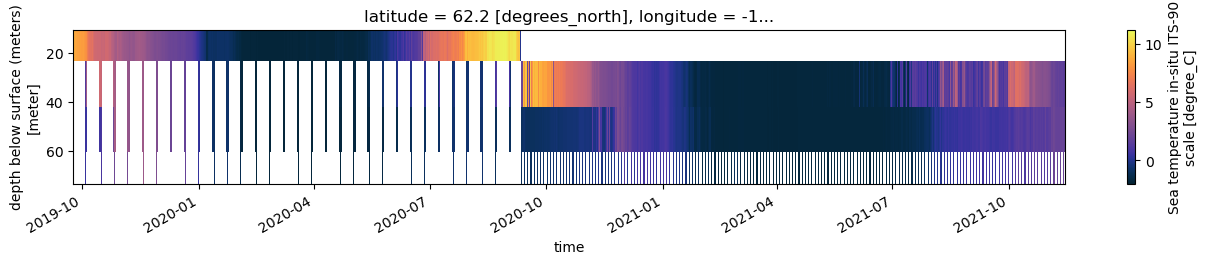

In [3]:
upper_temp = mfd.temperature.max(axis=0).max(axis=0).values
lower_temp = -2

fig, ax = plt.subplots(1,figsize=(16, 2))
mfd.temperature.T.plot(ax=ax,yincrease=False,vmin=lower_temp,vmax=upper_temp,cmap=cmocean.cm.thermal)

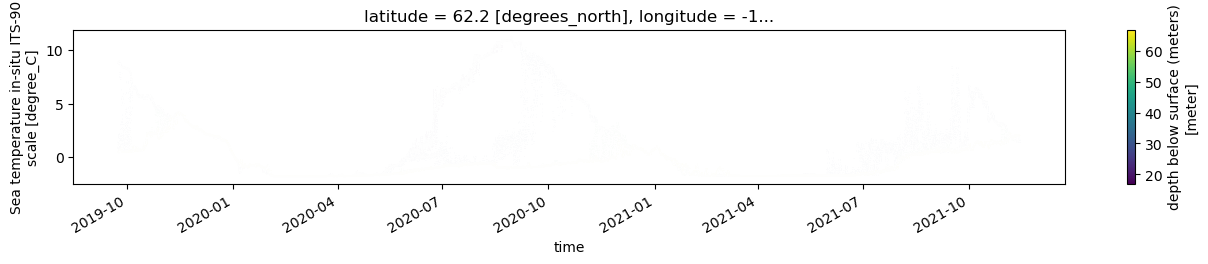

In [4]:
fig, ax = plt.subplots(1,figsize=(16, 2))
mfd.isel(latitude=0,longitude=0).plot.scatter(x="time",y="temperature",hue="depth",s=1,ax=ax)

**Note:** not everything has constant sample frequencies so if nan's are in the mix, then lineplots are less useful (see plot below)
Will want to resample to hourly or daily to evaluate those

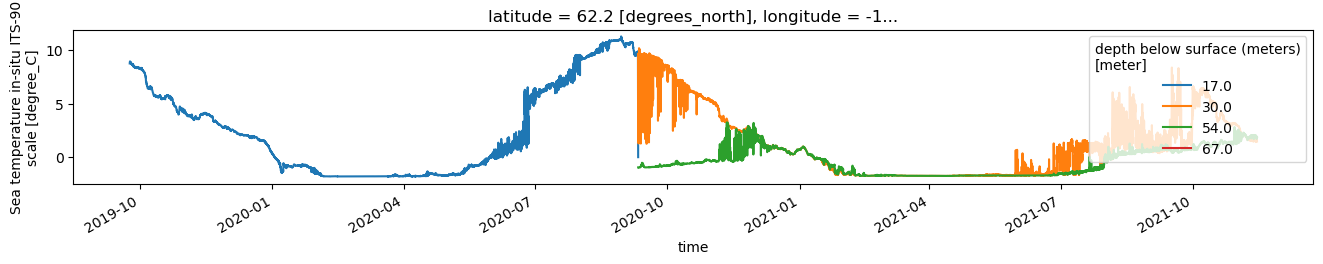

In [5]:
fig, ax = plt.subplots(1,figsize=(16, 2))
mfd.temperature.isel(latitude=0,longitude=0).plot.line(x="time",hue="depth",ax=ax);

## Salinity(full temporal resolution)

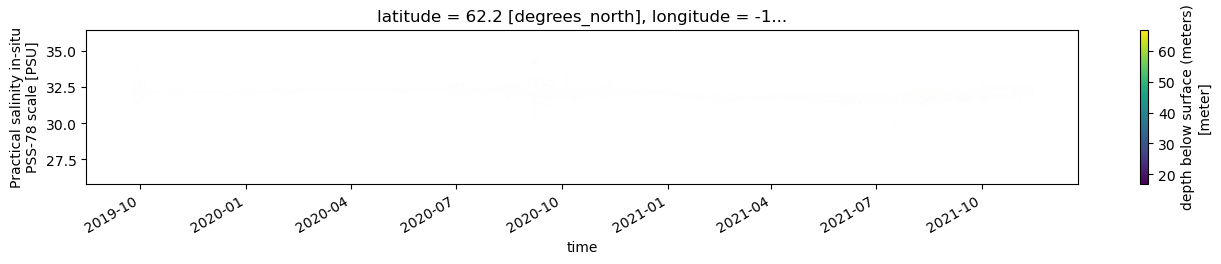

In [6]:
fig, ax = plt.subplots(1,figsize=(16, 2))
mfd.isel(latitude=0,longitude=0).plot.scatter(x="time",y="salinity",hue="depth",s=1,ax=ax)

## Pressure (full temporal resolution)

KeyError: 'pressure'

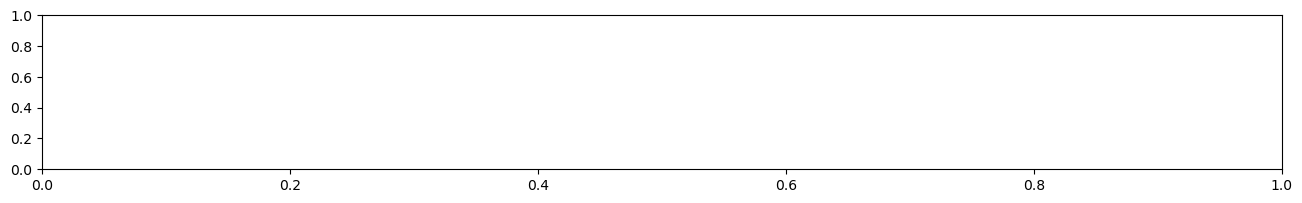

In [7]:
fig, ax = plt.subplots(1,figsize=(16, 2))
mfd.isel(latitude=0,longitude=0).plot.scatter(x="time",y="pressure",hue="depth",s=1,ax=ax)

## Hourly/Interpolated plots Plots

Because of the different timebases... quickly either interpolate (linearly) or downsample (this seems slower) to plot all series

In [8]:
# mfd_hourly = mfd.resample(time='1H').median() #not fast
mfd_up = mfd.interpolate_na("time")

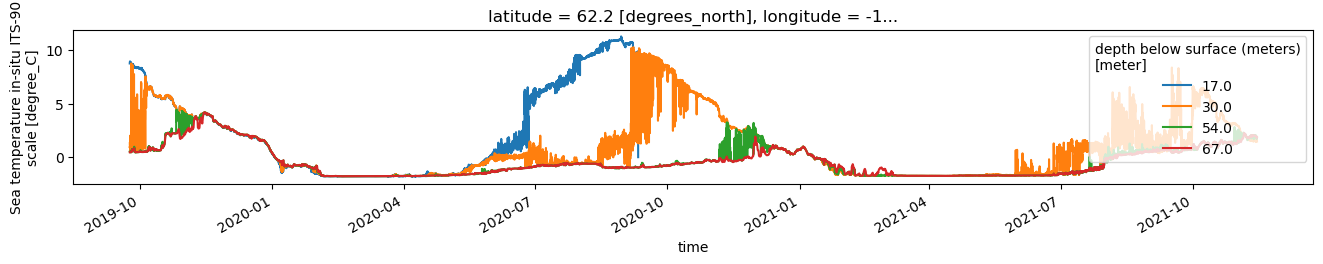

In [9]:
fig, ax = plt.subplots(1,figsize=(16, 2))
mfd_up.temperature.plot(x="time",hue="depth",ax=ax);

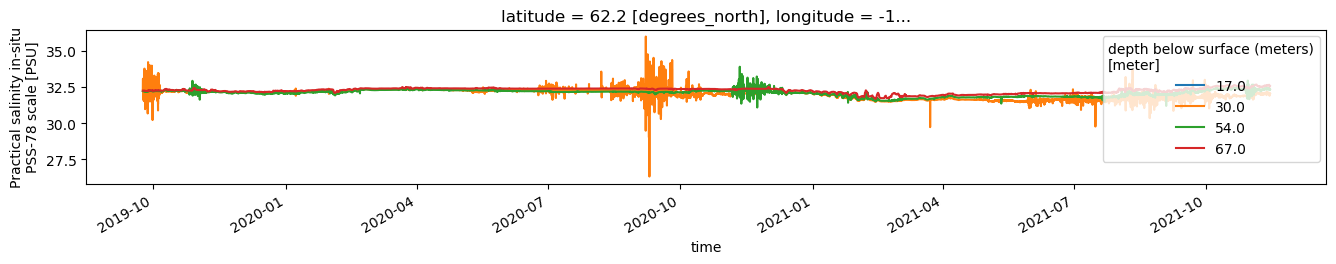

In [10]:
fig, ax = plt.subplots(1,figsize=(16, 2))
mfd_up.salinity.plot(x="time",hue="depth",ax=ax);

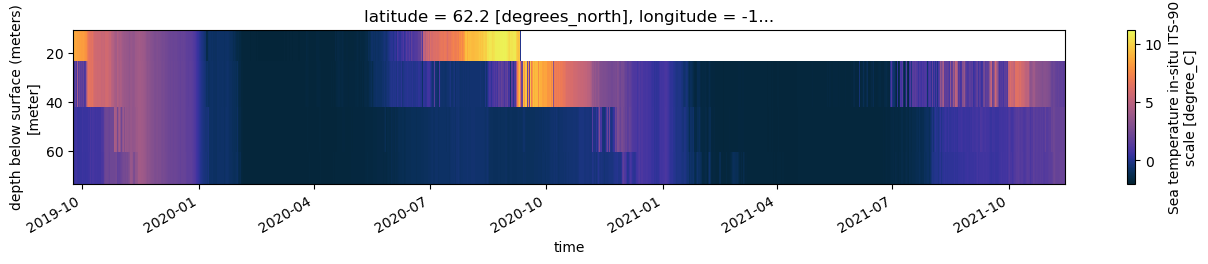

In [11]:
upper_temp = mfd_up.temperature.max(axis=0).max(axis=0).values
lower_temp = -2

fig, ax = plt.subplots(1,figsize=(16, 2))
mfd_up.temperature.T.plot(ax=ax,yincrease=False,vmin=lower_temp,vmax=upper_temp,cmap=cmocean.cm.thermal)

## Chlorophyll Hourly Interpolated Plots

AttributeError: 'Dataset' object has no attribute 'chlor_fluorescence'

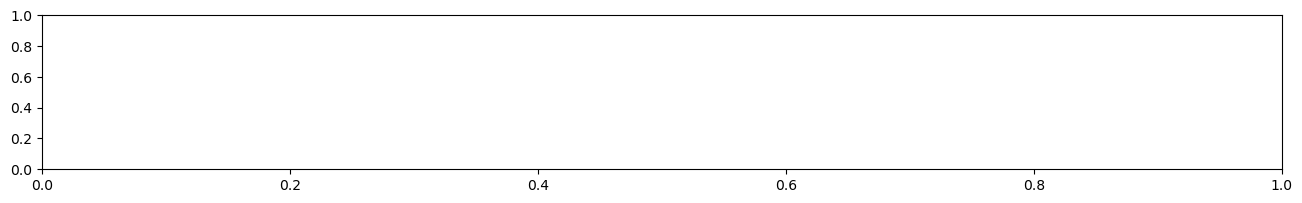

In [12]:
fig, ax = plt.subplots(1,figsize=(16, 2))
mfd_up.chlor_fluorescence.plot(x="time",hue="depth",ax=ax,add_legend=False);
(mfd_up.chlor_fluorescence*0).plot(x="time",hue="depth",ax=ax,add_legend=False);

AttributeError: 'Dataset' object has no attribute 'chlor_fluorescence'

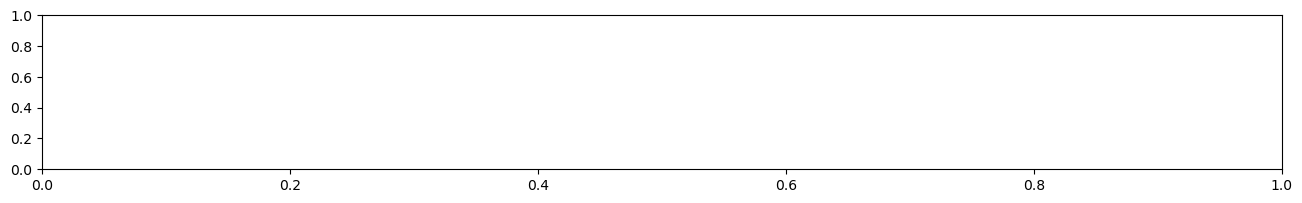

In [13]:
upper = 50
lower = 0

fig, ax = plt.subplots(1,figsize=(16, 2))
mfd_up.chlor_fluorescence.T.plot(ax=ax,yincrease=False,vmin=lower,vmax=upper,cmap=cmocean.cm.algae)

## Compare Timeseries to CTD Casts


- Recovery CTDXXX on Sikuliaq cruise, not yet obtained.

In [14]:
import ecofocipy.io.erddap as erddap

In [15]:
url = "http://ecofoci-field.pmel.noaa.gov:8080/erddap"

erddap.test_erddap_connection(url=url) #basic test for connection to internal server, no response is a good thing

In [16]:
#grap deploy/recover cast data from erddap hosted sets - you have to know which profile you want though
depcast = erddap.erddapCTDretrieve(url=url,cruiseid='dy1908',qclevel='final',concastno='009')
reccast = erddap.erddapCTDretrieve(url=url,cruiseid='dy2012',qclevel='preliminary',concastno='024')


**Add Poptop Timeseries** for 2019 M8 only, temperature only
- GPS fix starts 2021-02-11 21:00 (so assume all data after is not valid at M8)

In [17]:
from erddapy import ERDDAP
d = ERDDAP(server=url)
popdf = pd.read_csv(d.get_search_url(response='csv', search_for='poptop'))

dfs = {}
for dataset_id in popdf['Dataset ID'].values:
    print(dataset_id)
    try:
        d = ERDDAP(server=url,
            protocol='tabledap',
            response='csv'
        )
        d.dataset_id=dataset_id
    except:
        pass
    try:
        df_m = d.to_pandas(
                    index_col='time (UTC)',
                    parse_dates=True,
                    skiprows=(1,)  # units information can be dropped.
                    )
        df_m.sort_index(inplace=True)
        df_m.columns = [x[1].split()[0] for x in enumerate(df_m.columns)]
        df_m.index = df_m.index.rename('time')

        dfs.update({dataset_id:df_m})
    except:
        pass
    
# add data to MFD_up plot

2019_PopTop_300434063474010_deeper_data
2019_PopTop_300434063474010_shallow_data
2019_PopTop_300434063474010_irridium_position


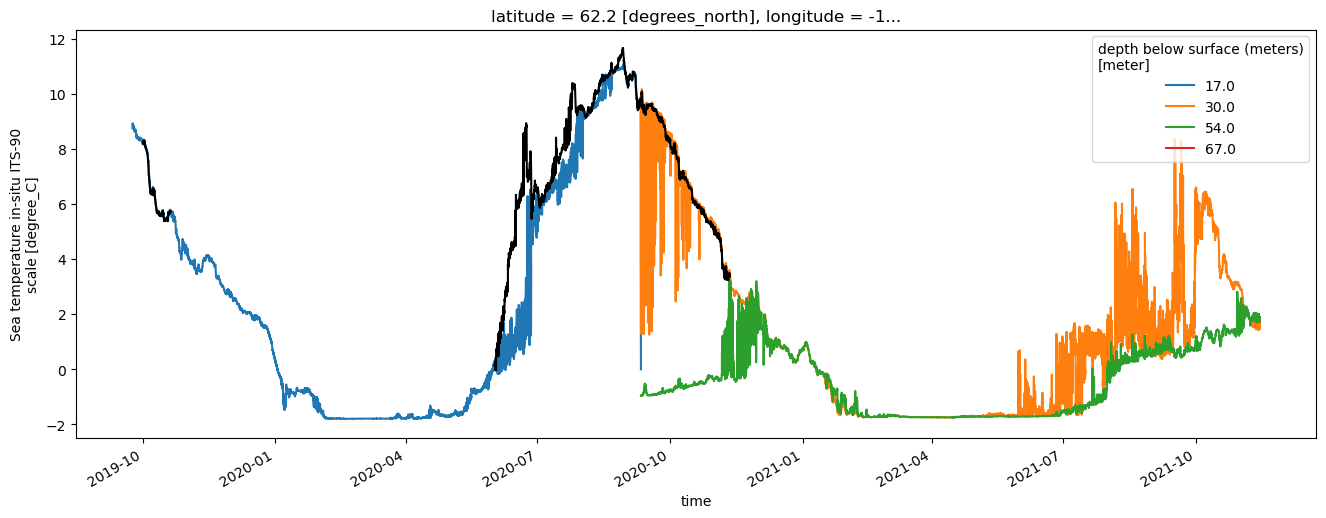

In [18]:
fig, ax = plt.subplots(1,figsize=(16, 6))
mfd.temperature.isel(latitude=0,longitude=0).plot.line(x="time",hue="depth",ax=ax);
dfs['2019_PopTop_300434063474010_deeper_data'].sr_temp.plot(ax=ax,c='k');
dfs['2019_PopTop_300434063474010_shallow_data'].sr_temp.plot(ax=ax,c='k');

In [19]:
#this was a big deal to install... so how does an SST product compare to M8 over the same period
url='https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplMURSST41_Lon0360.csvp?'+ \
'analysed_sst%5B(2019-10-01T09:00:00Z):1:(2021-11-23T09:00:00Z)%5D%5B(62.2):1:(62.2)%5D%5B(185.3):1:(185.3)%5D'
new=pd.read_csv(url,skiprows=0,parse_dates=True,index_col='time (UTC)')

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1,figsize=(16, 6))
mfd.temperature.isel(latitude=0,longitude=0).plot.line(x="time",hue="depth",ax=ax);
dfs['2019_PopTop_300434063474010_deeper_data'].sr_temp.plot(ax=ax,c='k');
dfs['2019_PopTop_300434063474010_shallow_data'].sr_temp.plot(ax=ax,c='k');
new['analysed_sst (degree_C)'].plot(color='grey',rot=0)


## QC Notes



(PJS needs to vet these)

## Generate to_edit files for PJS

- these are usually salinity focused and need the ctd casts as well as the salinity timeseries.
- save the native time scale, not the interpolated or upscaled version

In [27]:
with pd.ExcelWriter('19bs8a_salinity_to_edit.xlsx') as writer:  

    for depthkey in mfd.to_dataframe().salinity.groupby(level=[3]).groups.keys():
        print(f'{depthkey}')
        if not (mfd.to_dataframe().salinity.groupby(level=[3]).get_group(depthkey).dropna(how='all')).empty:
            print(f'saving {depthkey}')
            (mfd.to_dataframe().salinity.groupby(level=[3]).get_group(depthkey).dropna(axis=0)).to_excel(writer, sheet_name=str(depthkey))

    depcast.to_excel(writer, sheet_name=depcast.profile_id.unique()[0])
    reccast.to_excel(writer, sheet_name=reccast.profile_id.unique()[0])

17.0
30.0
saving 30.0
54.0
saving 54.0
67.0
saving 67.0
